In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Load Spotify dataset
file_path = './data/2415-Midterm-spotify_songs.csv'
spotify_data = pd.read_csv(file_path)

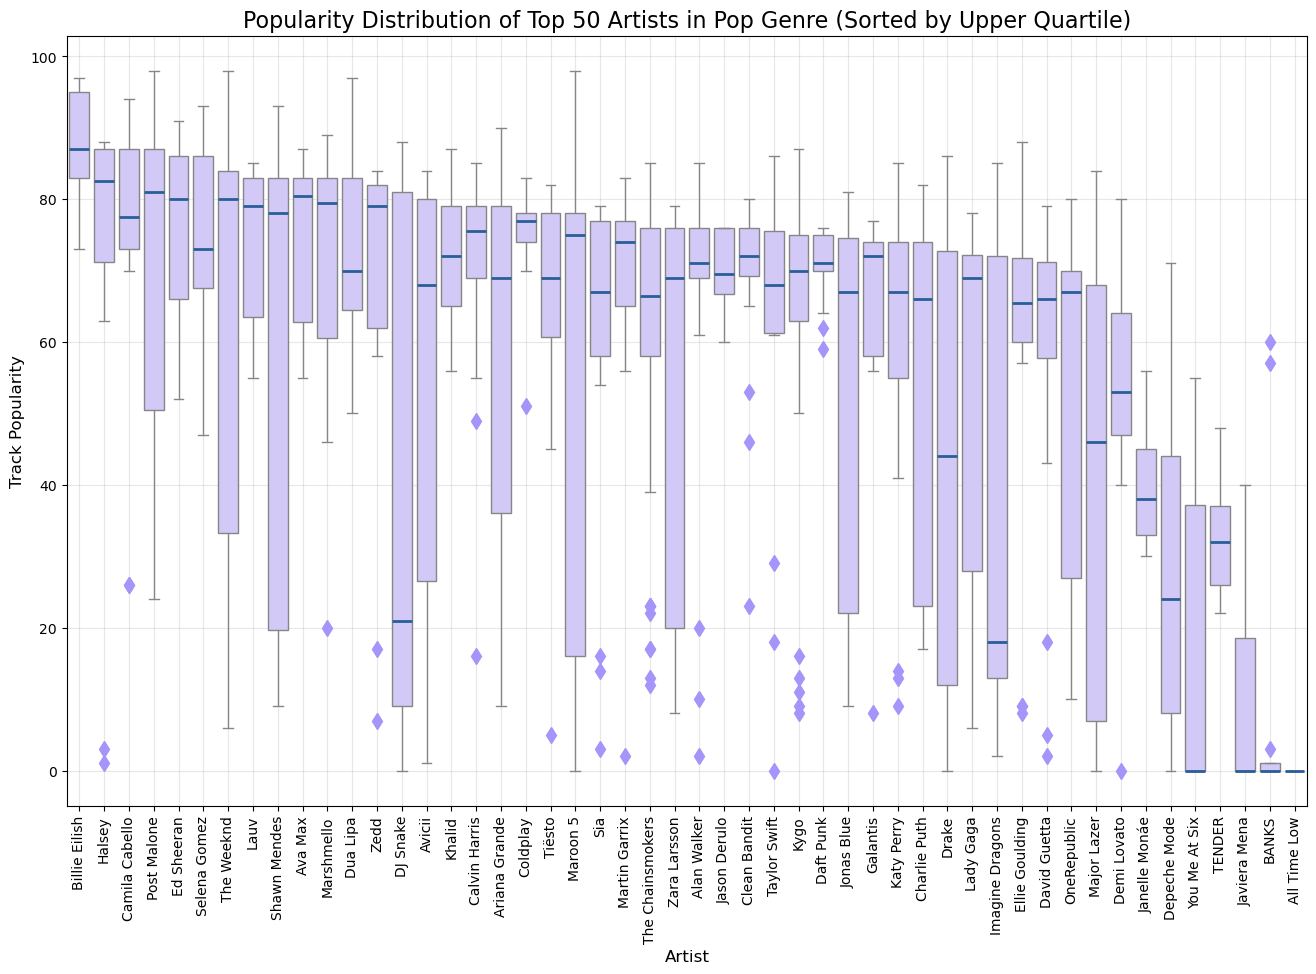

In [81]:
##### Title: Popularity Distribution of Top 50 Artists in Pop Genre (Sorted by Upper Quartile) #####

# Ensure the 'track_popularity' column is numeric, converting invalid entries to NaN
spotify_data['track_popularity'] = pd.to_numeric(spotify_data['track_popularity'], errors='coerce')

# Filter for the specified genre (pop)
genre = 'pop'
genre_data = spotify_data[spotify_data['playlist_genre'] == genre]

# Calculate top 50 artists by number of songs in the genre
top_50_artists = genre_data['track_artist'].value_counts().head(50).index
top_50_data = genre_data[genre_data['track_artist'].isin(top_50_artists)].copy()

# Calculate the upper quartile (75th percentile) for each artist and sort by it
artist_quartiles = (
    top_50_data.groupby('track_artist')['track_popularity']
    .quantile(0.75)
    .sort_values(ascending=False)
)
sorted_artists = artist_quartiles.index
top_50_data.loc[:, 'track_artist'] = pd.Categorical(top_50_data['track_artist'], categories=sorted_artists, ordered=True)

# Set a custom color palette
custom_palette = sns.color_palette([
    "#CDC1FF"
])

# Customize median line properties and outlier properties
median_props = {'color': '#295F98', 'linewidth': 2}  #295F98 8EACCD
flier_props = {
    'marker': 'd',
    'markerfacecolor': '#A594F9',
    'markeredgecolor': '#A594F9',
    'markersize': 8,
    'linestyle': 'none'
}

sns.set_palette(custom_palette)

# Plot the boxplot sorted by the upper quartile
plt.figure(figsize=(16, 10))
sns.boxplot(
    x='track_artist',
    y='track_popularity',
    data=top_50_data,
    order=sorted_artists,
    medianprops=median_props,
    flierprops=flier_props
)
plt.title(f'Popularity Distribution of Top 50 Artists in {genre.capitalize()} Genre (Sorted by Upper Quartile)', fontsize=16)
plt.xlabel('Artist', fontsize=12)
plt.ylabel('Track Popularity', fontsize=12)
plt.xticks(rotation=90, fontsize=10)
plt.grid(visible=True, alpha=0.3)
plt.show()


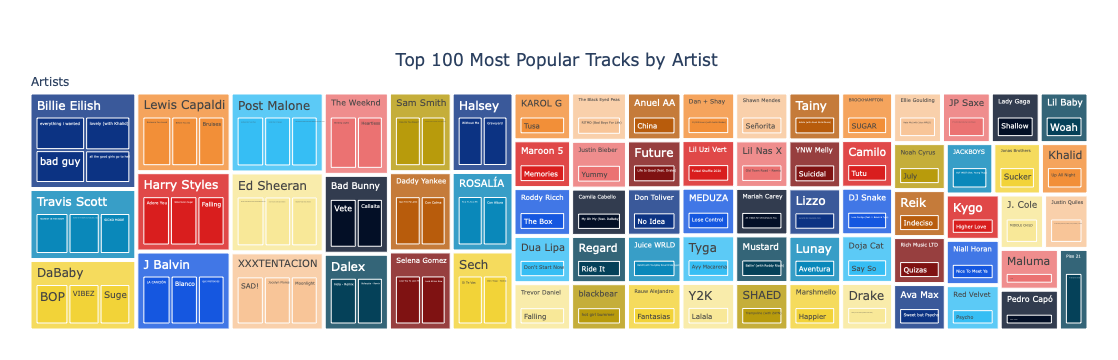

In [89]:
##### Title: Top 100 Most Popular Tracks by Popularity and Artist #####

# Group by artist and track name, calculate the mean popularity for each track, and sort in descending order
plot_df = (
    spotify_data.groupby(['track_artist', 'track_name'])['track_popularity']
    .mean() 
    .sort_values(ascending=False)  # Sort tracks by popularity (desc)
    .reset_index()  # Reset index for proper formatting
)

# Take the top 100 most popular tracks
top_100_tracks = plot_df.head(100) 

# Create the treemap
fig = px.treemap(
    top_100_tracks,  # Input data
    path=[px.Constant("Artists"), 'track_artist', 'track_name'],  # Hierarchy: root -> artist -> track
    values='track_popularity',  # Size of the blocks determined by popularity
    color_discrete_sequence=px.colors.diverging.Portland,  # eg. Portland / Tropic / Geyser
    labels={'track_popularity': 'Popularity'},  # Customize labels
)

# Update hover template
fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Popularity: %{value:.2f}<extra></extra>"
)

# Update and show layout
fig.update_layout(
    title={
        'text': "Top 100 Most Popular Tracks by Artist",
        'x': 0.5,
        'y': 0.85,
        'xanchor': 'center',
        'yanchor': 'top',
    },
    margin=dict(t=70, l=25, r=25, b=25),  # Adjust margins
    showlegend=False  # Hide legend
)
fig.show()


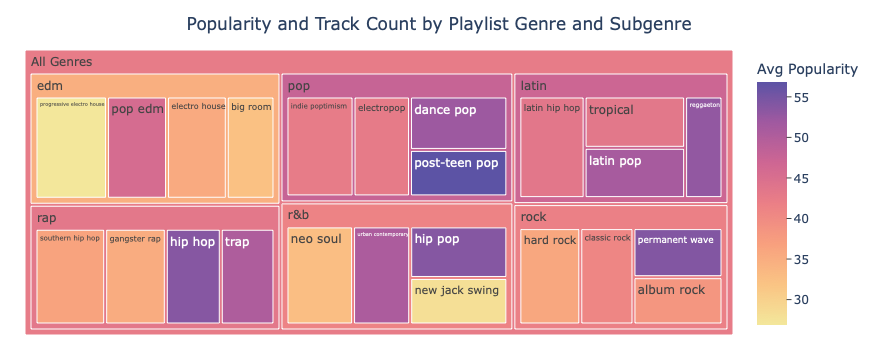

In [93]:
##### Title: Playlist Genre and Subgenre by Popularity and Track Count #####

# Group data by Playlist Genre and Subgenre, and calculate popularity statistics
plot_df = (
    spotify_data.groupby(['playlist_genre', 'playlist_subgenre'])['track_popularity']
    .agg(['count', 'mean'])  # Calculate track count and mean popularity
    .reset_index()
    .rename(columns={'count': 'Track Count', 'mean': 'Average Popularity'})
)

# Create treemap with customizable gradient color scale
color_scale = 'sunset'  # eg. Cividis Plasma magma pinkyl RdBu sunset PuBuGn Blues GnBu

fig = px.treemap(
    plot_df,
    path=[px.Constant('All Genres'), 'playlist_genre', 'playlist_subgenre'],  # Hierarchy: root -> genre -> subgenre
    values='Track Count',  
    color='Average Popularity',  # Color intensity is determined by average popularity
    color_continuous_scale=color_scale,  # define color
    labels={'Average Popularity': 'Avg Popularity', 'Track Count': 'Track Count'},  # Customize labels
)

# Update hover template
fig.update_traces(
    hovertemplate="<b>%{label}</b><br>Track Count: %{value}<br>Avg Popularity: %{color:.2f}<extra></extra>"
)

# Update and show layout (treemap)
fig.update_layout(
    title={
        'text': "Popularity and Track Count by Playlist Genre and Subgenre",
        'x': 0.5,
        'y': 0.95,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    margin=dict(t=50, l=25, r=25, b=25),  # Adjust margins
    coloraxis_colorbar=dict(
        title="Avg Popularity",  # Add color bar title
        ticks="outside"  # Position ticks outside
    ),
    showlegend=False  # Hide legend
)
fig.show()


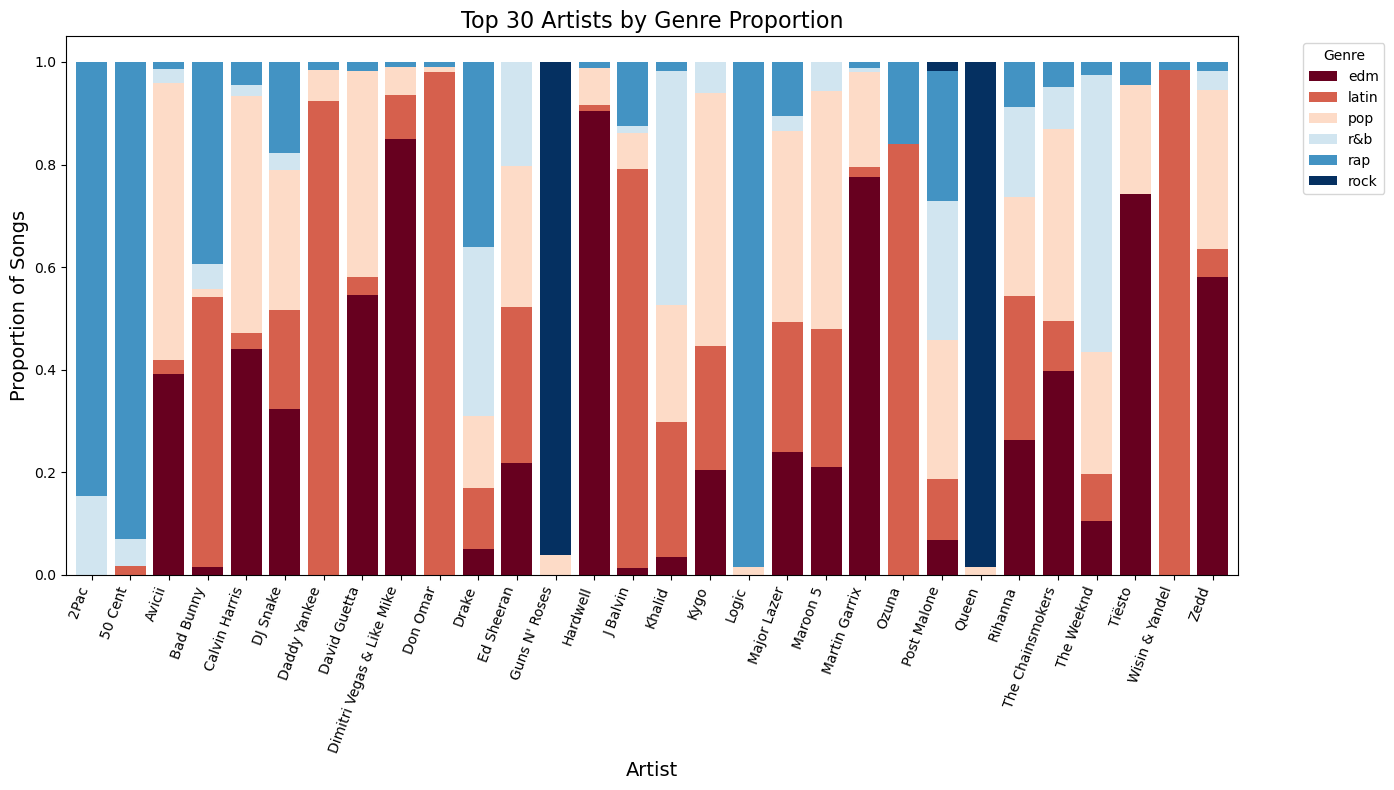

In [51]:
##### Title: Genre Proportion Across Top 30 Artists #####

# Calculate the top 30 artists by track count
top_artists = spotify_data['track_artist'].value_counts().head(30).index

# Filter the dataset for these top artists
top_artist_data = spotify_data[spotify_data['track_artist'].isin(top_artists)]

# Calculate the number of songs for each artist in each genre
artist_genre_counts = top_artist_data.groupby(['track_artist', 'playlist_genre']).size().unstack(fill_value=0)

# Convert the counts to proportions
artist_genre_proportions = artist_genre_counts.div(artist_genre_counts.sum(axis=1), axis=0)

# Plot the stacked bar chart
plt.figure(figsize=(14, 8))

# Change colormap
custom_colormap = 'RdBu'  # colormap: viridis cool plasma RdBu Spectral coolwarm summer pink GnBu PuBu
artist_genre_proportions.plot(kind='bar', stacked=True, colormap=custom_colormap, width=0.8, ax=plt.gca())

# Display the plot
plt.title('Top 30 Artists by Genre Proportion', fontsize=16)
plt.xlabel('Artist', fontsize=14)
plt.ylabel('Proportion of Songs', fontsize=14)
plt.xticks(rotation=70, ha='right', fontsize=10)  # Rotate x-axis
plt.yticks(fontsize=10)
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()  # Ensure the layout fits the figure
plt.show()


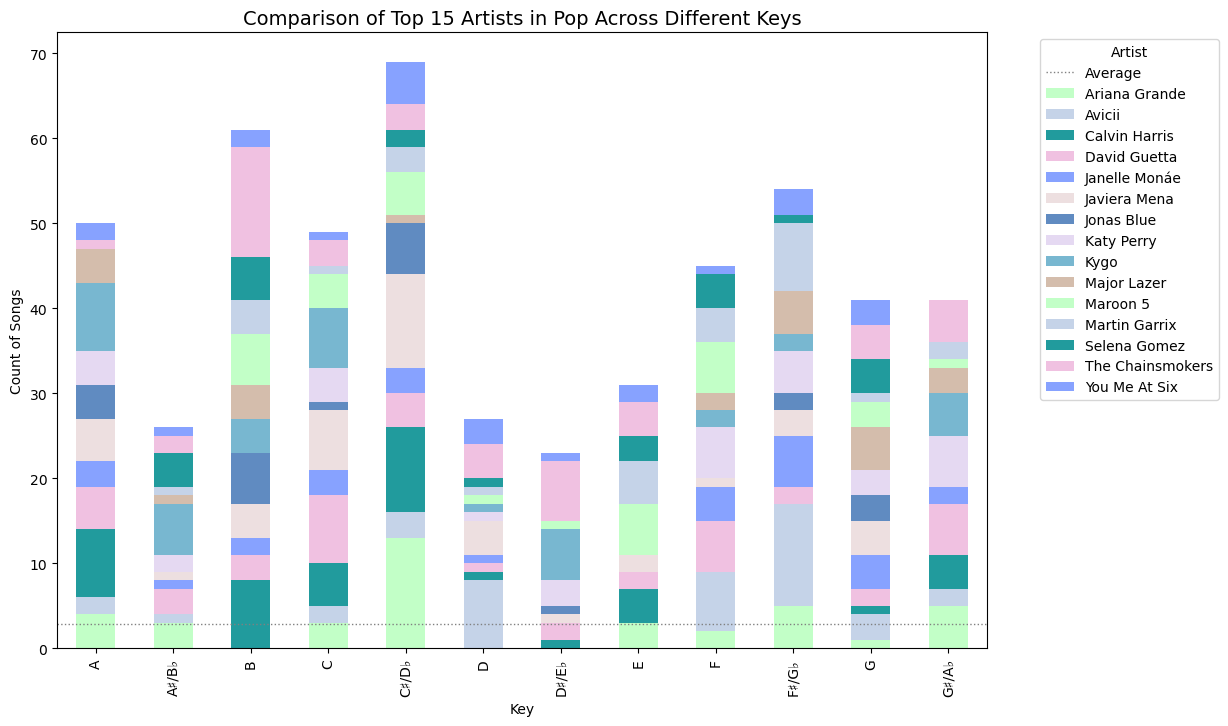

In [63]:
#####  Title: Comparison of Top 15 Artists in Pop Across Different Keys #####

# Define the dictionary to map key values to musical key names
key_mapping = {
    -1: "No Key",    # Special case where no key is detected
    0: "C",          # Key mappings follow standard pitch class notation
    1: "C♯/D♭",
    2: "D",
    3: "D♯/E♭",
    4: "E",
    5: "F",
    6: "F♯/G♭",
    7: "G",
    8: "G♯/A♭",
    9: "A",
    10: "A♯/B♭",
    11: "B"
}

# Filter the dataset for the specified genre -> pop
genre = 'pop'  # Replace with other genres - rock edm r&b
genre_data = spotify_data[spotify_data['playlist_genre'] == genre].copy()

# Convert numerical key values to key names using assign method
genre_data = genre_data.assign(key_name=genre_data['key'].map(key_mapping))

# Filter the dataset for the top 15 artists with the highest number of tracks
top_artists = genre_data['track_artist'].value_counts().head(15).index
filtered_data = genre_data[genre_data['track_artist'].isin(top_artists)]

# Group the data by key and artist, and count the number of songs for each combination
key_artist_count = filtered_data.groupby(['key_name', 'track_artist']).size().unstack(fill_value=0)

# Customize color palette
custom_colors = ["#C2FFC7", "#C5D3E8", "#219B9D", "#F0C1E1", "#87A2FF", 
                 "#EDDFE0", "#608BC1", "#E5D9F2", "#78B7D0", "#D4BDAC"]

# Stacked bar chart to visualize the distribution of tracks by key and artist
key_artist_count.plot(kind='bar', stacked=True, figsize=(12, 8), color=custom_colors)
plt.title("Comparison of Top 15 Artists in Pop Across Different Keys", fontsize=14)
plt.xlabel("Key")
plt.ylabel("Count of Songs")

# Add a horizontal line indicating the average number of songs across keys
plt.axhline(y=key_artist_count.values.mean(), color='gray', linestyle=':', linewidth=1, label="Average")

# Add legend to indicate artist names and display chart
plt.legend(title="Artist", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


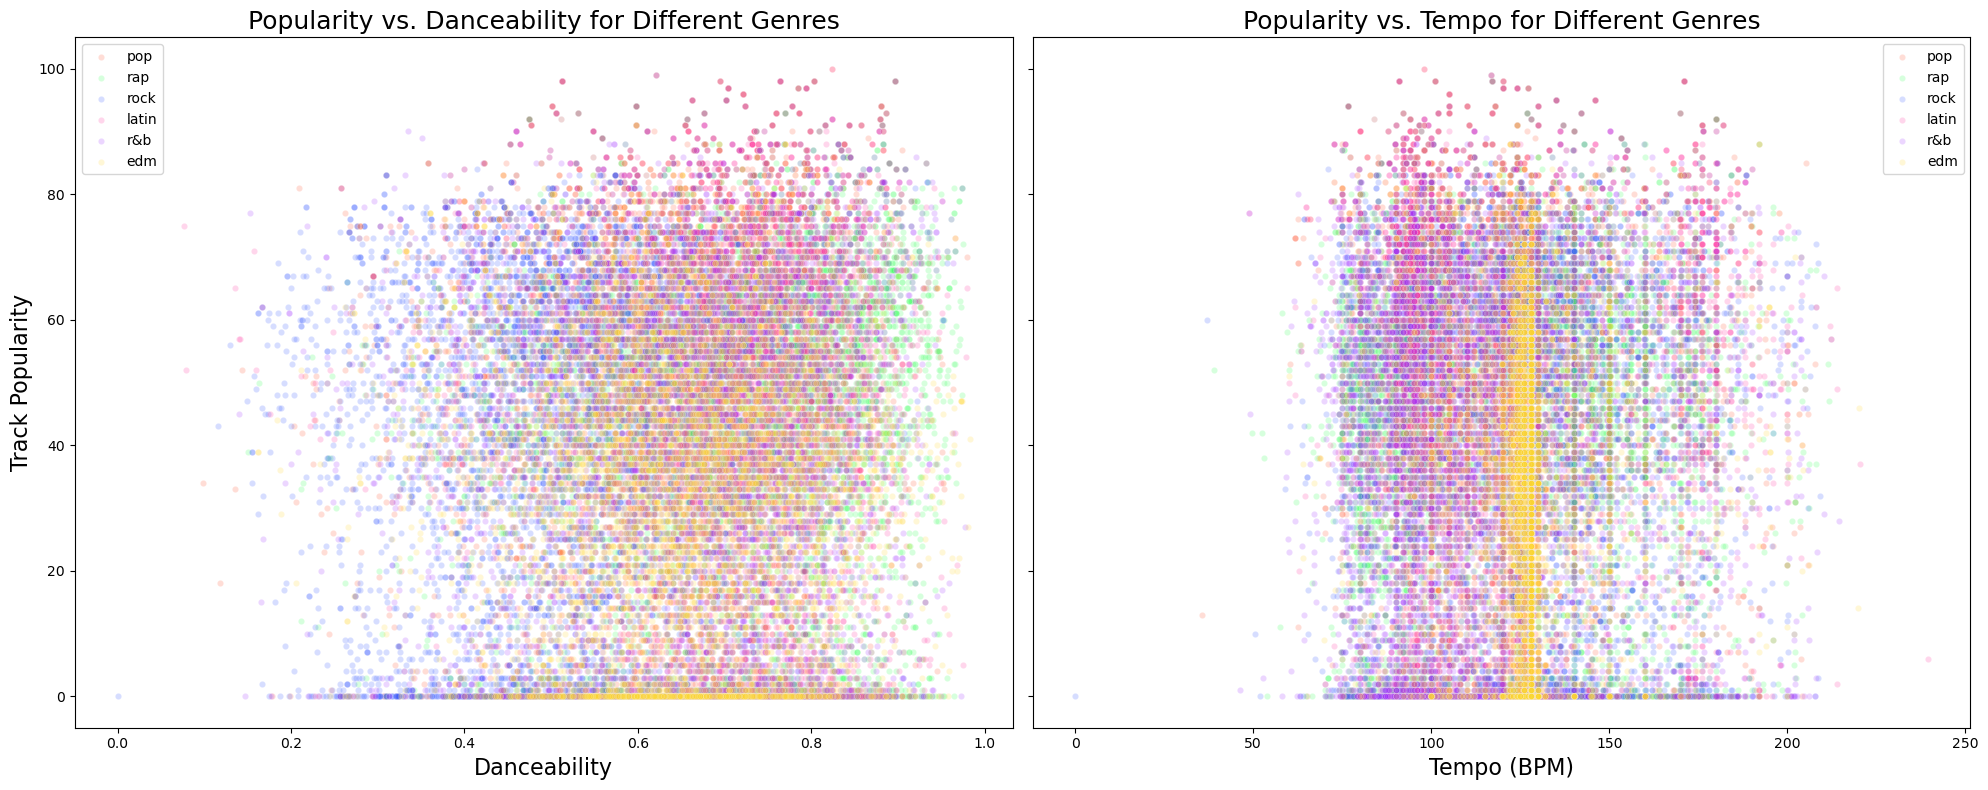

In [95]:
##### Title: Popularity vs. Danceability and Tempo (BPM) for Different Genres #####

# Customize colors for genres
genre_colors = {
    'pop': '#FF5733',    # Orange
    'rap': '#33FF57',    # Green
    'rock': '#3357FF',   # Blue
    'latin': '#FF33A1',  # Pink
    'r&b': '#A133FF',    # Purple
    'edm': '#FFD733'     # Yellow
}

# Define transparency
base_alpha = 0.2

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot 1: Popularity vs. Danceability (All genres)
for genre, color in genre_colors.items():
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['danceability'], 
        y=genre_data['track_popularity'], 
        color=color, label=genre, alpha=base_alpha, s=20, ax=ax1
    )

ax1.set_title('Popularity vs. Danceability for Different Genres',fontsize=18)
ax1.set_xlabel('Danceability', fontsize=16)
ax1.set_ylabel('Track Popularity', fontsize=16)

# Plot 2: Popularity vs. Tempo(BPM) (All genres)
for genre, color in genre_colors.items():
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['tempo'], 
        y=genre_data['track_popularity'], 
        color=color, label=genre, alpha=base_alpha, s=20, ax=ax2
    )

ax2.set_title('Popularity vs. Tempo for Different Genres', fontsize=18)
ax2.set_xlabel('Tempo (BPM)', fontsize=16)
ax1.set_ylabel('Track Popularity', fontsize=16)

# Adjust legends for both subplots
handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


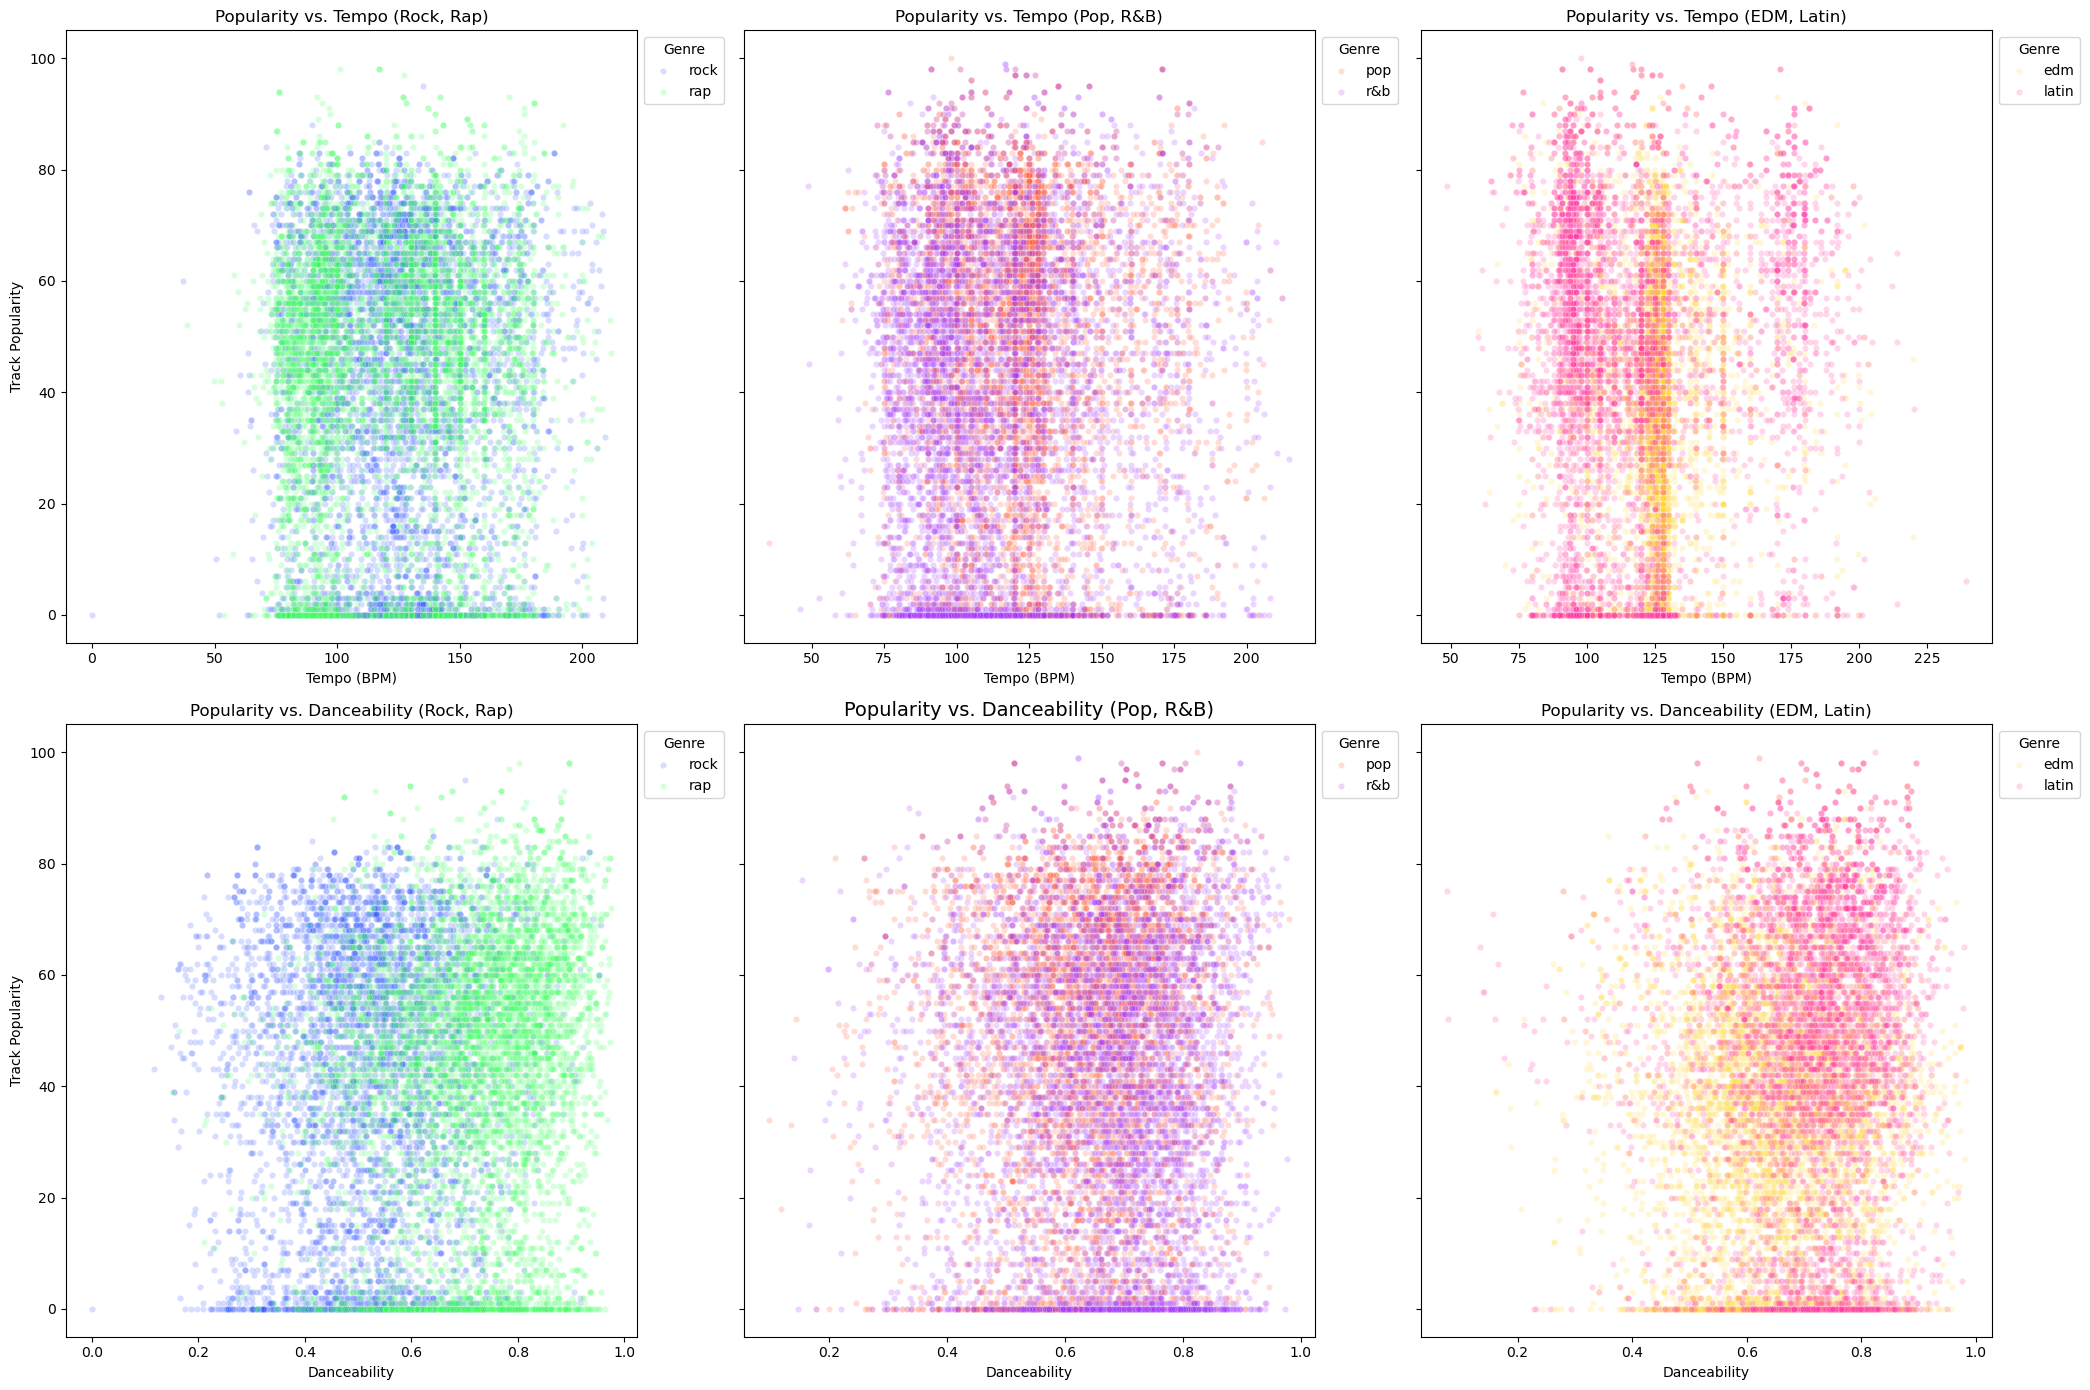

In [69]:
##### Title: Popularity vs. Danceability and Tempo for Different Genre Comparisons #####

# Customize colors for genres
genre_colors = {
    'pop': '#FF5733',    # Orange
    'rap': '#33FF57',    # Green
    'rock': '#3357FF',   # Blue
    'latin': '#FF33A1',  # Pink
    'r&b': '#A133FF',    # Purple
    'edm': '#FFD733'     # Yellow
}
x
# Define transparency
base_alpha = 0.2

# Create a figure with 2 rows and 3 columns of subplots
fig, axes = plt.subplots(2, 3, figsize=(21, 14), sharey=True)


### 1st First row: Popularity vs. Tempo(BPM)

# Plot 1: Rock and Rap
for genre in ['rock', 'rap']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['tempo'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[0, 0]
    )
axes[0, 0].set_title('Popularity vs. Tempo (Rock, Rap)')
axes[0, 0].set_xlabel('Tempo (BPM)')
axes[0, 0].set_ylabel('Track Popularity')

# Plot 2: Pop and R&B
for genre in ['pop', 'r&b']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['tempo'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[0, 1]
    )
axes[0, 1].set_title('Popularity vs. Tempo (Pop, R&B)')
axes[0, 1].set_xlabel('Tempo (BPM)')

# Plot 3: EDM and Latin
for genre in ['edm', 'latin']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['tempo'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[0, 2]
    )
axes[0, 2].set_title('Popularity vs. Tempo (EDM, Latin)')
axes[0, 2].set_xlabel('Tempo (BPM)')


#### 2nd Second row: Popularity vs. Danceability

# Plot 4: Rock and Rap
for genre in ['rock', 'rap']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['danceability'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[1, 0]
    )
axes[1, 0].set_title('Popularity vs. Danceability (Rock, Rap)')
axes[1, 0].set_xlabel('Danceability')
axes[1, 0].set_ylabel('Track Popularity')

# Plot 5: Pop and R&B
for genre in ['pop', 'r&b']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['danceability'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[1, 1]
    )
axes[1, 1].set_title('Popularity vs. Danceability (Pop, R&B)', fontsize=14)
axes[1, 1].set_xlabel('Danceability')

# Plot 6: EDM and Latin
for genre in ['edm', 'latin']:
    genre_data = spotify_data[spotify_data['playlist_genre'] == genre]
    sns.scatterplot(
        x=genre_data['danceability'], y=genre_data['track_popularity'], 
        color=genre_colors[genre], label=genre, alpha=base_alpha, s=20, ax=axes[1, 2]
    )
axes[1, 2].set_title('Popularity vs. Danceability (EDM, Latin)')
axes[1, 2].set_xlabel('Danceability')

# Adding legends for all subplots
for i in range(2):  # Loop over rows
    for j in range(3):  # Loop over columns
        handles, labels = axes[i, j].get_legend_handles_labels()
        axes[i, j].legend(handles, labels, title='Genre', bbox_to_anchor=(1, 1), loc='upper left')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
